### Setup

MSTICpy includes a feature called [nbinit](https://msticpy.readthedocs.io/en/latest/msticpy.nbtools.html?highlight=nbinit#module-msticpy.nbtools.nbinit) that helps makes the process of installing and importing modules into a notebook environment cleaner and easier. This was developed to allow for a clearer starting cell in notebooks and to avoid users being presented with a very large cell block at the top of a notebook.

In [1]:
from IPython.display import Image

from msticpy.nbtools import nbinit
extra_imports = [
    "msticpy.nbtools.timeseries, display_timeseries_anomolies",
    "msticpy.analysis.timeseries, timeseries_anomalies_stl",
    "msticpy.nbtools.morph_charts, MorphCharts",
    "datetime, datetime",
    "msticpy.nbtools.security_alert_graph, create_alert_graph",
    "msticpy.nbtools.security_alert_graph, add_related_alerts",
    "msticpy.nbtools.nbdisplay, draw_alert_entity_graph",
    "msticpy.nbtools.foliummap, get_map_center",
    "msticpy.nbtools.foliummap, FoliumMap",
    "msticpy.sectools.ip_utils, convert_to_ip_entities",
    "msticnb,,nb",
    "msticnb.common, TimeSpan",
    "datetime, datetime",
    "msticpy.nbtools.ti_browser, browse_results"
    
]

nbinit.init_notebook(
    namespace=globals(),
    additional_packages=["pyvis"],
    extra_imports=extra_imports,
);

WIDGET_DEFAULTS = {
    "layout": widgets.Layout(width="95%"),
    "style": {"description_width": "initial"},
}

Processing imports....
All packages are already installed
6 notebooklets loaded.
Checking configuration....
No errors found.
No warnings found.
Setting options....


### Data Acquisition - Splunk
A key starting point with many notebooks is ingesting data on which to conduct analysis or investigation of. MSTICpy contains a number of [query providers](https://msticpy.readthedocs.io/en/latest/data_acquisition/DataProviders.html) to allow users to query and return data from a number of sources. Below we are using the Splunk query provider to return data from our Splunk instance.<br> Data is returned in a Pandas [DataFrame]()<br>
Here we are getting a summary of our network traffic  in the time period we are interested in.

In [2]:
# Initialize a Splunk provider and connect to our Splunk instance.
splunk_prov = QueryProvider("Splunk")
splunk_prov.connect(host="splunk-mstic.westus2.cloudapp.azure.com", username="admin", password="xxx")

Connected to Splunk successfully !!


In [8]:
# Define a Splunk Query and run it.
splunk_query = """
search index=blackhat sourcetype=network earliest=0 | table TimeGenerated, TotalBytesSent
"""

stldemo = splunk_prov.exec_query(splunk_query)
stldemo['TimeGenerated'] = pd.to_datetime(stldemo['TimeGenerated'])
stldemo.set_index('TimeGenerated', inplace=True)
stldemo.sort_index(inplace=True)

168

## Timeseries Analysis to detected Anomalies
Once we have collected data there are a number of analytics pacakges within MSTICpy to help understand the data and identify potential security incidents. Below we use MSTICpy's [time series analysis](https://msticpy.readthedocs.io/en/latest/msticpy.analysis.html?highlight=timeseries#module-msticpy.analysis.timeseries) machine learning capabilities to look for anomalies in our network traffic.<br>
As well as computing anomalies we visualize the data so that we can more easily see where these anomalies present themselves.

In [10]:
# Conduct our timeseries analyis
output = timeseries_anomalies_stl(stldemo)
# Visualize the timeseries and any anomalies
display_timeseries_anomolies(data=output, y= 'TotalBytesSent')

Loading BokehJS ...

Column(id='2222', ...)

In [11]:
# Identify when the anomalies occur so that we can use this timnerange to scope the next stage of our investigation.
start = output[output['anomalies']==1]['TimeGenerated'].min()
end = output[output['anomalies']==1]['TimeGenerated'].max() +  pd.to_timedelta(1, unit='h')
md(f"Anomolous session start time: {start}")
md(f"Anomolous session end time: {end}")

## Enrich and Pivot on IP Addresses
Once analyis has identified an event of interest we need additional context to be anle to effectively conduct a security investigation. MSTICpy has a range of features to help enrich key data types and provide that context.

In [12]:
# Splunk?
net_data = pd.read_csv(
    "raw_network.csv", index_col=["TimeGenerated"], parse_dates=["TimeGenerated"], infer_datetime_format=True)
# We need to identify what network endpoints are associated with the anomalies
grouped_df = net_data.groupby(['SoureIP', 'DestinationIP'])
noisy_hosts = grouped_df['TotalBytesSent'].agg(np.sum).sort_values(ascending=False)
md("Top talkers during anomolous session: ", 'bold')
display(noisy_hosts[:5])
source_ip = noisy_hosts.index[0][0]
dest_ip = noisy_hosts.index[0][1]

SoureIP        DestinationIP
Our Source IP  31.220.60.108    8328
10.16.12.1     40.124.45.19     1004
10.0.3.5       40.124.45.19      621
10.4.5.12      13.71.172.130     247
               40.77.232.95      189
Name: TotalBytesSent, dtype: int64

### Network data enrichment
MSTICpy has a number of tools to help analysts investigate an IP address, using open source information such as [passive DNS](https://msticpy.readthedocs.io/en/latest/data_acquisition/TIProviders.html?highlight=passive%20dns#use-to-do-a-passive-dns-lookup) data, [IP geolocation](https://msticpy.readthedocs.io/en/latest/data_acquisition/GeoIPLookups.html) and [threat intelligence](https://msticpy.readthedocs.io/en/latest/data_acquisition/TIProviders.html) feeds to provide valuable context.

In [13]:
from ipwhois import IPWhois
from msticpy.sectools.ip_utils import get_whois_info, get_ip_type
ti = TILookup()

# Get and display WhoIs data
md(f"Target IP: {dest_ip}", 'bold')
md(f"{dest_ip} is a {get_ip_type(dest_ip)} IP address")
whois_info = get_whois_info(dest_ip)
md(f'Whois Registrar Info :', styles=["bold"])
md(f"ASN Owner: {whois_info[0]}")
md(f"ASN Address: {whois_info[1]['nets'][0]['address']}")
    
# Get Passive DNS results
result = ti.lookup_ioc(observable="31.220.60.108", ico_type="ipv4", ioc_query_type="passivedns", providers=["XForce"])
md(f"Passive DNS records for {dest_ip}:", styles=["bold"])
for res in ti.result_to_df(result)['RawResult'][0]['Passive']['records']:
    print(res['value']," - ", res['last'])
    
# Lookup ip IPAddress in threat intel feeds
resp = ti.lookup_ioc(observable=dest_ip)
md(f"Threat Intel results for {dest_ip}:", styles=["bold"])
ti.result_to_df(resp)

Using Open PageRank. See https://www.domcop.com/openpagerank/what-is-openpagerank


joblly.com  -  2020-07-09T10:48:00Z
cdn-xhr.com  -  2020-07-09T10:48:00Z
rackxhr.com  -  2020-07-09T10:48:00Z
hixrq.net  -  2020-07-09T10:48:00Z
idpcdn-cloud.com  -  2020-07-09T10:48:00Z
thxrq.com  -  2020-07-09T10:48:00Z
hivnd.net  -  2020-07-09T10:48:00Z


,Ioc,IocType,QuerySubtype,Provider,Result,Severity,Details,RawResult,Reference,Status
OTX,31.220.60.108,ipv4,None,OTX,True,high,"{'pulse_count': 5, 'names': ['Credit card skimmer targets ASP.NET sites', 'Credit card skimmer t...","{'sections': ['general', 'geo', 'reputation', 'url_list', 'passive_dns', 'malware', 'nids_list',...",https://otx.alienvault.com/api/v1/indicators/IPv4/31.220.60.108/general,0
XForce,31.220.60.108,ipv4,None,XForce,True,high,"{'score': 7.1, 'cats': {'Malware': 71}, 'categoryDescriptions': {'Malware': 'This category lists...","{'ip': '31.220.60.108', 'history': [{'created': '2012-03-22T07:26:00.000Z', 'reason': 'Regional ...",https://api.xforce.ibmcloud.com/ipr/31.220.60.108,0


As well as returning the raw data from these enrichment sources MSTICpy has features to allow for visualization of that data. Below we using the [Folium Map](https://msticpy.readthedocs.io/en/latest/visualization/FoliumMap.html) feature to plot the IP location on a interactive map.

In [14]:
# Plot IP geolocation on a map
ip = convert_to_ip_entities(dest_ip)
location = get_map_center(ip)
folium_map = FoliumMap(location = location, zoom_start=4)
md('<h3>Locaiton of remote IP</h3>')
icon_props = {'color': 'red'}
folium_map.add_ip_cluster(ip_entities=ip, **icon_props)
display(folium_map.folium_map)

### Host Lookup
Once we have some context on our remote IP address we can pivot our investigation to look at the local host that has been communicating with it.

### Data Acquisition from Azure Sentinel
As well as Splunk MSTICpy has a query provider for Azure Sentinel, for the next phase of our investigation we are going to use this query provider to acquire data.<br><br>
AS well as providing connection details directly to our query provider we can store details in a [msticpy configuration file](https://msticpy.readthedocs.io/en/latest/getting_started/msticpyconfig.html), here we use the [Workspace Config](https://msticpy.readthedocs.io/en/latest/msticpy.common.html?highlight=WorkspaceConfig#msticpy.common.wsconfig.WorkspaceConfig) feature to access this configuration and retrieve the items we need to access Azure Sentinel.

In [15]:
# Initalize and connect to Azure Sentinel using details from our config file.
qry_prov = QueryProvider('LogAnalytics')
wkspace = WorkspaceConfig()
qry_prov.connect(wkspace.code_connect_str)

Please wait. Loading Kqlmagic extension...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
# Query Azure Sentinel to get host details.
query = """
Heartbeat
| where ComputerIP == "20.185.182.48"
"""

host = qry_prov.exec_query(query)
host_name = host['Computer'].iloc[0]
md(f"Host to investigate: {host_name}")

<IPython.core.display.Javascript object>

## Investigate Host
Now that we have identified our host we wante to perform some standard analysis to get a summary of the host. Rather than code these steps individually each time we create a notebook that investigates hosts we have grouped together several MSTICpy features and investigation steps into a single function we call a notebooklet - by calling this notebooklet we can easily conduct analysis that would require hundreds of lines of code if coded directly in a notebook.

In [19]:
# For testing to remove
start = datetime(2020,7,9,0,0,1)
end = datetime(2020,7,9,23,59,1) 

### Use a notebooklet

In [20]:
# Initalize our notebooklets
nb.init()
host_name="BlackHatDemoHos"
tspan = TimeSpan(start=start, end=end)
# Select our notebooklet
nblet = nb.nblts.azsent.host.HostSummary()
# Run our notebooklet
out = nblet.run(value=host_name, timespan=tspan)

Loaded providers: LogAnalytics, azuredata, geolitelookup, tilookup


Getting data from SecurityEvent...


<IPython.core.display.Javascript object>

Getting data from Syslog...


<IPython.core.display.Javascript object>

Unique host found: BlackHatDemoHos


{ 'AdditionalData': {},
  'AzureDetails': { 'ResourceDetails': { 'Admin User': 'mstic_admin',
                                         'Azure Location': 'eastus',
                                         'Disks': [],
                                         'Image': 'Windows-10 rs5-pro',
                                         'Network Interfaces': [ '/subscriptions/40dcc8bf-0478-4f3b-b275-ed0a94f2c013/resourceGroups/BlackHatDemo/providers/Microsoft.Network/networkInterfaces/blackhatdemohost86'],
                                         'Tags': "{'Role': 'Demo'}",
                                         'VM Size': 'Standard_B2s'},
                    'ResourceGroup': 'BlackHatDemo',
                    'ResourceId': '/subscriptions/40dcc8bf-0478-4f3b-b275-ed0a94f2c013/resourceGroups/BlackHatDemo/providers/Microsoft.Compute/virtualMachines/BlackHatDemoHost',
                    'ResourceProvider': 'Microsoft.Compute',
                    'ResourceType': 'virtualMachines',
            

<IPython.core.display.Javascript object>

Loading BokehJS ...

Getting data from Bookmarks...


<IPython.core.display.Javascript object>

### Azure Data
As well as providing query providers to get data from SIEM solutions such as Azure Sentinel MSTICpy also has the capability to acquire data from other sources such as Azure. Below we use [these features](https://msticpy.readthedocs.io/en/latest/data_acquisition/AzureData.html) to collect information and metrics on our host.<br>
We then use the MSTICpy interactive [timeline visualization](https://msticpy.readthedocs.io/en/latest/visualization/EventTimeline.html) in order to display this data.

In [21]:
from msticpy.data.azure_data import AzureData
# Initalize and connect to Azure
az = AzureData()
az.connect()
# Get details on our subscription and virtal machines
sub_id = az.get_subscriptions().iloc[0]['Subscription ID']
resources = az.get_resources(sub_id)
display(resources[resources['name'] == "BlackHatDemoHost"])
res_id = resources[resources['name'] == "BlackHatDemoHost"].iloc[0]['resource_id']

,resource_id,name,resource_type,location,tags,plan,properties,kind,managed_by,sku,identity,state
285,/subscriptions/40dcc8bf-0478-4f3b-b275-ed0a94f2c013/resourceGroups/BlackHatDemo/providers/Micros...,BlackHatDemoHost,Microsoft.Compute/virtualMachines,eastus,{'Role': 'Demo'},None,None,None,None,None,None,None


In [22]:
az.get_resource_details(resource_id=res_id, sub_id=sub_id)

{'resource_id': '/subscriptions/40dcc8bf-0478-4f3b-b275-ed0a94f2c013/resourceGroups/BlackHatDemo/providers/Microsoft.Compute/virtualMachines/BlackHatDemoHost',
 'name': 'BlackHatDemoHost',
 'resource_type': 'Microsoft.Compute/virtualMachines',
 'location': 'eastus',
 'tags': {'Role': 'Demo'},
 'plan': None,
 'properties': {'vmId': '3f2b6a14-4c02-41aa-a2e8-6859ee4c7847',
  'hardwareProfile': {'vmSize': 'Standard_B2s'},
  'storageProfile': {'imageReference': {'publisher': 'MicrosoftWindowsDesktop',
    'offer': 'Windows-10',
    'sku': 'rs5-pro',
    'version': 'latest',
    'exactVersion': '17763.1282.2006061952'},
   'osDisk': {'osType': 'Windows',
    'name': 'BlackHatDemoHost_OsDisk_1_dd1ef27d863e4e14ab3b446a4ab3ab20',
    'createOption': 'FromImage',
    'caching': 'ReadWrite',
    'managedDisk': {'id': '/subscriptions/40dcc8bf-0478-4f3b-b275-ed0a94f2c013/resourceGroups/BLACKHATDEMO/providers/Microsoft.Compute/disks/BlackHatDemoHost_OsDisk_1_dd1ef27d863e4e14ab3b446a4ab3ab20'}},
   '

In [24]:
# Get metrics from the Azure virtual machine.
mets = az.get_metrics(metrics="Percentage CPU,Disk Read Bytes,Disk Write Bytes", resource_id=res_id, sub_id=sub_id, sample_time="hour", start_time=2)

disk_read_data = mets['Disk Read Bytes']
disk_read_data['Type'] = 'Disk Read'
disk_write_data = mets['Disk Write Bytes']
disk_write_data['Type'] = "Disk Write"
disk_data = pd.concat([disk_read_data, disk_write_data])

# Visualize those metrics
nbdisplay.display_timeline_values(data=mets['Percentage CPU'], title="Host CPU Usage", time_column = 'Time', y='Data', height=400, source_columns=['Time', 'Data'], kind='line', range_tool=False)
nbdisplay.display_timeline_values(data=disk_data, title="Host Disk Usage", time_column = 'Time', y='Data', height=400, source_columns=['Time', 'Data'], kind='line', group_by='Type', range_tool=False)

Loading BokehJS ...

Loading BokehJS ...

Figure(id='2889', ...)

### Host Alerts
One thing we want to investigate in more detail are any security alerts associated with the host. Security Alerts contain complex, detailed data that is hard to analyse in a regular Pandas DataFrame. To make it easier MSTICpy provides an interactive widget to allow you to pick alerts from a  list and see ht efoll details in an expanded output format.

In [25]:
from datetime import datetime
start = datetime(2020,7,9,15,0,1)
end = datetime(2020,7,9,20,0,1)
related_alerts = qry_prov.SecurityAlert.list_related_alerts(start=start, end=end, host_name=host_name)
display(related_alerts)
related_alerts['CompromisedEntity'] = related_alerts['Computer']
def disp_full_alert(alert):
    global related_alert
    related_alert = SecurityAlert(alert)
    return nbdisplay.format_alert(related_alert, show_entities=True)

rel_alert_select = nbwidgets.SelectAlert(alerts=related_alerts, action=disp_full_alert)
rel_alert_select.display()

<IPython.core.display.Javascript object>

,TenantId,TimeGenerated,AlertDisplayName,AlertName,Severity,Description,ProviderName,VendorName,VendorOriginalId,SystemAlertId,ResourceId,SourceComputerId,AlertType,ConfidenceLevel,ConfidenceScore,IsIncident,StartTimeUtc,EndTimeUtc,ProcessingEndTime,RemediationSteps,ExtendedProperties,Entities,SourceSystem,WorkspaceSubscriptionId,WorkspaceResourceGroup,ExtendedLinks,ProductName,ProductComponentName,AlertLink,Type,Computer,src_hostname,src_accountname,src_procname,host_match,acct_match,proc_match
0,52b1ab41-869e-4138-9e40-2a4457f09bf0,2020-07-09 16:41:10+00:00,RDP Brute Force,RDP Brute Force,Medium,,ASI Scheduled Alerts,Microsoft,5b161b5d-ef7a-4068-b090-034b4637289a,7edb89af-7068-5ab0-de73-c737b1c42ee6,,,52b1ab41-869e-4138-9e40-2a4457f09bf0_765132a3-cf2f-40cf-b45c-cd6be9b942b7,Unknown,NaN,False,2020-07-09 16:35:07+00:00,2020-07-09 16:35:39+00:00,2020-07-09 16:41:10+00:00,,"{\r\n ""Query"": ""let bruteforce_hosts = (\r\nSecurityEvent\r\n| where Computer contains \""blackh...","[\r\n {\r\n ""$id"": ""3"",\r\n ""Address"": ""174.127.235.80"",\r\n ""Type"": ""ip""\r\n },\r\n ...",Detection,40dcc8bf-0478-4f3b-b275-ed0a94f2c013,asihuntomsworkspacerg,,Azure Sentinel,Scheduled Alerts,,SecurityAlert,BlackHatDemoHos,BlackHatDemoHos,,,True,False,False
1,52b1ab41-869e-4138-9e40-2a4457f09bf0,2020-07-09 17:09:22+00:00,Suspicious Activity Detected,Suspicious Activity Detected,Medium,Analysis of host data has detected a sequence of one or more processes running on BlackHatDemoHo...,Detection-WarmPathV2,Microsoft,a12616bd-422c-4ffe-b386-755755bb6ece,2518079882220869999_a12616bd-422c-4ffe-b386-755755bb6ece,/subscriptions/40dcc8bf-0478-4f3b-b275-ed0a94f2c013/resourceGroups/BlackHatDemo/providers/Micros...,73a015ec-e2b6-4bf7-b353-ebeafb54254e,VM_SuspiciousActivity,Unknown,0.0,False,2020-07-09 16:36:17+00:00,2020-07-09 16:38:38+00:00,2020-07-09 17:09:57+00:00,"[\r\n ""Review each of the individual line items in this alert to see if you recognize them as l...","{\r\n ""Machine Name"": ""BlackHatDemoHos"",\r\n ""Command List"": ""PING command was executed.\nNew ...","[\r\n {\r\n ""$id"": ""4"",\r\n ""HostName"": ""BlackHatDemoHos"",\r\n ""AzureID"": ""/subscripti...",Detection,40dcc8bf-0478-4f3b-b275-ed0a94f2c013,asihuntomsworkspacerg,,Azure Security Center,,https://portal.azure.com/#blade/Microsoft_Azure_Security/AlertBlade/alertId/2518079882220869999_...,SecurityAlert,BlackHatDemoHos,BlackHatDemoHos,,,True,False,False
2,52b1ab41-869e-4138-9e40-2a4457f09bf0,2020-07-09 17:09:22+00:00,Suspicious Activity Detected,Suspicious Activity Detected,Medium,Analysis of host data has detected a sequence of one or more processes running on BlackHatDemoHo...,Detection-WarmPathV2,Microsoft,a12616bd-422c-4ffe-b386-755755bb6ece,cfb09e3f-a443-e6c5-3f62-d0e4ca8f272e,/subscriptions/40dcc8bf-0478-4f3b-b275-ed0a94f2c013/resourceGroups/BlackHatDemo/providers/Micros...,73a015ec-e2b6-4bf7-b353-ebeafb54254e,VM_SuspiciousActivity,Unknown,0.0,False,2020-07-09 16:36:17+00:00,2020-07-09 16:38:38+00:00,2020-07-09 17:09:57+00:00,"[\r\n ""Review each of the individual line items in this alert to see if you recognize them as l...","{\r\n ""Machine Name"": ""BlackHatDemoHos"",\r\n ""Command List"": ""PING command was executed.\nNew ...","[\r\n {\r\n ""$id"": ""4"",\r\n ""HostName"": ""BlackHatDemoHos"",\r\n ""AzureID"": ""/subscripti...",Detection,40dcc8bf-0478-4f3b-b275-ed0a94f2c013,asihuntomsworkspacerg,,Azure Security Center,,https://portal.azure.com/#blade/Microsoft_Azure_Security/AlertBlade/alertId/2518079882220869999_...,SecurityAlert,BlackHatDemoHos,BlackHatDemoHos,,,True,False,False
3,52b1ab41-869e-4138-9e40-2a4457f09bf0,2020-07-09 17:56:10+00:00,RDP Brute Force,RDP Brute Force,Medium,,ASI Scheduled Alerts,Microsoft,a0b3c279-66c0-4671-9289-9f6c27b003e1,09ee81ac-17a0-8e29-a027-e639c76ca9ec,,,52b1ab41-869e-4138-9e40-2a4457f09bf0_765132a3-cf2f-40cf-b45c-cd6be9b942b7,Unknown,NaN,False,2020-07-09 17:49:57+00:00,2020-07-09 17:50:54+00:00,2020-07-09 17:56:10+00:00,,"{\r\n ""Query"":

,6
TenantId,52b1ab41-869e-4138-9e40-2a4457f09bf0
TimeGenerated,2020-07-09 18:56:11+00:00
AlertDisplayName,RDP Brute Force
AlertName,RDP Brute Force
Severity,Medium
Description,
ProviderName,ASI Scheduled Alerts
VendorName,Microsoft
VendorOriginalId,2c33c0ff-8690-490a-b681-e121cb1c6e88
SystemAlertId,9a63306f-3c72-da0a-4f81-57cb498cbb03


### Draw graph of alerts
Graphs provide a great way to understand the relationship between items. As alerts are often associated with multiple different entities being able to view a graph of alerts and thier entities helps analysts identify important connections. MSTICpy provide a [dedicated feature](https://msticpy.readthedocs.io/en/latest/msticpy.data.html?highlight=create_alert_graph#msticpy.nbtools.security_alert_graph.create_alert_graph) for graphing and plotting alert information.

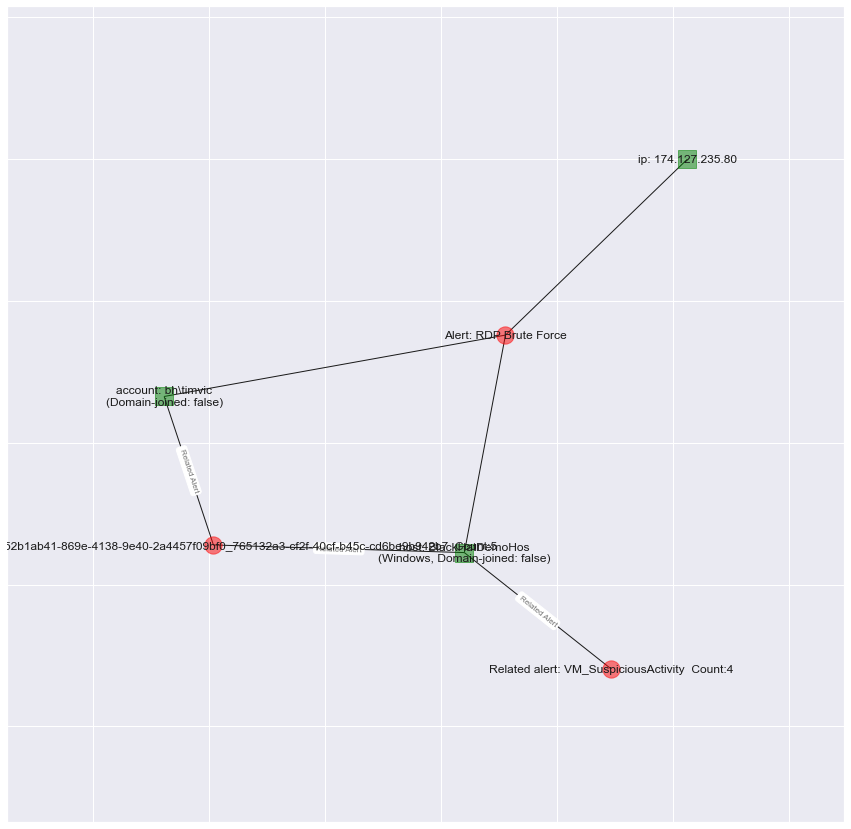

In [26]:
alert = SecurityAlert(rel_alert_select.selected_alert)
grph = create_alert_graph(alert)
full_grph = add_related_alerts(related_alerts, grph)
draw_alert_entity_graph(full_grph, width=15)

### Logon Sessions
Logon events are key to undetsanding any host based activity. We have previously used MSTICpy's [timeline feature](https://msticpy.readthedocs.io/en/latest/visualization/EventTimeline.html) to display value based data such as our Azure virtual machine metrics, as well as discrete data such as alerts, however we can also use it to display multiple types of discrete data on the same timeline. This is particularily useful for Windows logon events were we want to see the different types of logon events.

In [27]:
# Acquire data
host_logons = qry_prov.WindowsSecurity.list_host_logons(start=start,end=end, host_name=host_name)

# Display timeline
tooltip_cols = ["TimeGenerated", "Account", "LogonType", 'TimeGenerated']
nbdisplay.display_timeline(data=host_logons, alert=rel_alert_select.selected_alert, title="Host Logons", source_columns = tooltip_cols, group_by = "LogonType", height=200)

<IPython.core.display.Javascript object>

Loading BokehJS ...

Column(id='3267', ...)

When presented with a large number of events such as we have here its useful to cluster these into a more managable number of groups. MSTICpy contains [clustering features](https://msticpy.readthedocs.io/en/latest/msticpy.sectools.html?highlight=cluster_events#msticpy.sectools.eventcluster.dbcluster_events) that can be used against a number of data types. Once clustering is complete we use another [widget](https://msticpy.readthedocs.io/en/latest/msticpy.nbtools.html?highlight=SelectItem#msticpy.nbtools.nbwidgets.SelectItem) to let the user select the cluster they want to focus on.

In [28]:
from msticpy.sectools.eventcluster import dbcluster_events, add_process_features, _string_score

logon_features = host_logons.copy()
logon_features["AccountNum"] = host_logons.apply(lambda x: _string_score(x.Account), axis=1)
logon_features["TargetUserNum"] = host_logons.apply(lambda x: _string_score(x.TargetUserName), axis=1)
logon_features["LogonHour"] = host_logons.apply(lambda x: x.TimeGenerated.hour, axis=1)

(clus_logons, _, _) = dbcluster_events(data=logon_features, time_column="TimeGenerated", cluster_columns=["AccountNum", "LogonType", "TargetUserNum"], max_cluster_distance=0.0001)

dist_logons = clus_logons.sort_values("TimeGenerated")[["TargetUserName", "TimeGenerated", "LastEventTime", "LogonType", "ClusterSize"]]
dist_logons = dist_logons.apply(lambda x: (
        f"{x.TargetUserName}:    "
        f"(logontype {x.LogonType})   "
        f"timerange: {x.TimeGenerated} - {x.LastEventTime}    "
        f"count: {x.ClusterSize}"
    ),
    axis=1,
)
dist_logons = {v: k for k, v in dist_logons.to_dict().items()}

def show_logon(idx):
    return nbdisplay.format_logon(pd.DataFrame(clus_logons.loc[idx]).T)

logon_wgt = nbwidgets.SelectItem(description="Select logon cluster to examine", item_dict=dist_logons, action=show_logon,height="200px", width="100%", auto_display=True)

Account: timvicAccount Domain: BlackHatDemoHosLogon Time: 2020-07-09 17:50:11.700000+00:00Logon type: 3(Network)User Id/SID: S-1-5-21-3334416894-4278249820-3875274378-1006 SID S-1-5-21-3334416894-4278249820-3875274378-1006 is local machine or domain accountSubject (source) account: -/-Logon process: NtLmSsp Authentication: NTLMSource IpAddress: 174.127.235.80Source Host: PEBRYAN-LAPTOP1Logon status:


In [29]:
# We can reset our timeframe based on the selected cluster.
start = clus_logons.loc[logon_wgt.value]['FirstEventTime']
end = clus_logons.loc[logon_wgt.value]['LastEventTime']

### Process Tree
A valuable thing for analysts to understand when looking at a host is the processes executed on the host, and the relationship between them. MSTICpy contains features to build and visualize [process trees](https://msticpy.readthedocs.io/en/latest/visualization/ProcessTree.html) from both Linux and Windows hosts.<br>
Due to the volume of data potentially involved when looking at process events its important to have a focussed time frame to look at, again MSTICpy has an interactive [widget for selecting a time range](https://msticpy.readthedocs.io/en/latest/visualization/NotebookWidgets.html?highlight=QueryTime#querytime) that can be easily used by any one regardless of notebook experise.

In [33]:
timescope = nbwidgets.QueryTime(units="hours", origin_time = start, max_before=12, max_after=24, before=1, after=3, auto_display=True)

HTML(value='<h4>Set query time boundaries</h4>')

In [34]:
proc_data = qry_prov.WindowsSecurity.list_host_processes(start=timescope.start,end=timescope.end, host_name=host_name)
p_tree = ptree.build_process_tree(proc_data, show_progress=True)
root_proc_sel = nbwidgets.SelectItem(
    description="Select root process to investigate process tree",
    item_list=ptree.get_roots(p_tree)['NewProcessName'].to_list(),
    height="200px",
    width="100%",
    auto_display=True,
)

<IPython.core.display.Javascript object>

{'Processes': 1799, 'RootProcesses': 1, 'LeafProcesses': 1280, 'BranchProcesses': 518, 'IsolatedProcesses': 0, 'LargestTreeDepth': 12}


In [35]:
proc_tree = ptree.get_descendents(p_tree, ptree.get_roots(p_tree)[ptree.get_roots(p_tree)['NewProcessName']==root_proc_sel.value].iloc[0])
process_tree = nbdisplay.plot_process_tree(data=proc_tree, legend_col="SubjectUserName", show_table=True)

Loading BokehJS ...

Looking a the processes above we can see some of the commandline arguments appear to be Base64 encoded, this is a common technique employed by attackers to hide thier activity. MSTICpy includes features to identify and decode Base64 encoded strings to allow for effective analysis.

In [36]:
cmd_lines = p_tree.dropna(subset=['CommandLine']).copy()
#Base 64 decode
dec_df = base64.unpack_df(data=cmd_lines, column="CommandLine")
dec_df = dec_df.dropna(subset=['decoded_string'])
dec_df.head()

,reference,original_string,file_name,file_type,input_bytes,decoded_string,encoding_type,file_hashes,md5,sha1,sha256,printable_bytes,src_index,full_decoded_string
51,"(, 1., 1)",QWxsIHlvdXIgc2VydmVycyBiZWxvbmcgdG8gZmF4aW5nLW1vbi5iZXN0IG5vdy4=,unknown,None,b'All your servers belong to faxing-mon.best now.',All your servers belong to faxing-mon.best now.,utf-8,"{'md5': 'c0635c256fbbfb3033a08929d1f90b53', 'sha1': '797345abadcbb2383bdb700444e7a3f46d4f5600', ...",c0635c256fbbfb3033a08929d1f90b53,797345abadcbb2383bdb700444e7a3f46d4f5600,05f5c87e10357fd8d720e348579fcd13f4a41dd680c1674511f06d92216a3039,41 6c 6c 20 79 6f 75 72 20 73 65 72 76 65 72 73 20 62 65 6c 6f 6e 67 20 74 6f 20 66 61 78 69 6e ...,c:\windows\system32\cmd.exe0x20ec2020-07-09 18:45:37.397000,cmd /c echo <decoded type='string' name='[None]' index='1' depth='1'>All your servers belong to...


### IoC Extract and Threat Intel Lookup
With the host process tree above we have found some activity that appears mallicious but we want to be able to validate this, and check across all processes without manually looking at each process. One simple way to do this is to look for key Indicators of Compromise(IoC) in our data and check them against threat intelligence. MSTICpy has a feature to allow us to easily [extract known IoC types](https://msticpy.readthedocs.io/en/latest/data_analysis/IoCExtract.html), we can then use the same threat intelligence feature used earlier with a single IP address to look up multiple IoCs.

In [38]:
# Extract IoCs from command lines
ioc_ex = IoCExtract()
cmd_iocs = cmd_lines.mp_ioc.extract(columns=['CommandLine'], ioc_types=['ipv4','dns'])
b64_iocs = dec_df.mp_ioc.extract(columns=['decoded_string'], ioc_types=['ipv4','dns'])
iocs = pd.concat([cmd_iocs,b64_iocs])
iocs = iocs.drop_duplicates(subset=['IoCType','Observable']).copy()
iocs.sample(5)

,IoCType,Observable,SourceIndex
34,ipv4,3.1.53.0,c:\windows\system32\applytrustoffline.exe0x1be82020-07-09 18:04:04.947000
33,ipv4,019.108.627.0,c:\windows\system32\applytrustoffline.exe0x1be82020-07-09 18:04:04.947000
20,ipv4,127.0.0.1,c:\windows\system32\ping.exe0xf7c2020-07-09 16:36:19.427000
4,ipv4,14.56.102.0,c:\program files\windowsapps\microsoft.skypeapp_14.56.102.0_x64__kzf8qxf38zg5c\skypeapp.exe0x1d0...
29,ipv4,019.105.618.0,c:\windows\system32\applytrustoffline.exe0x1be82020-07-09 18:04:04.947000


In [41]:
# TI Lookups
ti_resp = ti.lookup_iocs(data=iocs, obs_col="Observable")
browse_results(ti_resp, severities=['high','warning'])

### Review domain
We have appear to have identified a malicious domain to go with the IP address identified earlier in our investigation. In order to complete our investigation we want to get some context on this domain in the same way we did with the IP address. Again MSTICpy has a number of tools to help with this, including features to [validate a domain](https://msticpy.readthedocs.io/en/latest/getting_started/PackageSummary.html?highlight=screenshot#domain-utils) and [screenshot a URL](https://msticpy.readthedocs.io/en/latest/getting_started/PackageSummary.html?highlight=screenshot#domain-utils). 

In [42]:
dom = "secure-ssl-sec.com"
dom_val = domain_utils.DomainValidator()
md(f"Is {dom} a valid domain?  {dom_val.validate_tld(dom)}")
md(f"Is {dom} resolvable? {dom_val.is_resolvable(dom)}")
md(f"Is the TLS cert used by {dom} in abuse.ch's abuse list? {dom_val.in_abuse_list(dom)[0]}")

Getting screenshot


IntProgress(value=0, max=40)

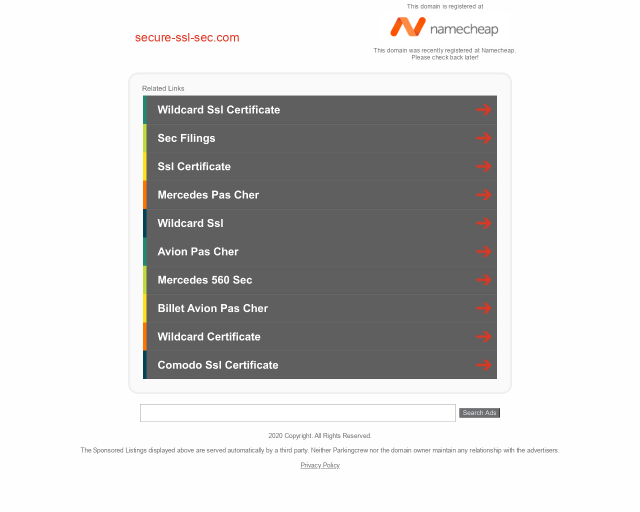

In [43]:
image_data = domain_utils.screenshot("secure-ssl-sec.com")
with open('screenshot.png', 'wb') as f:
        f.write(image_data.content)

display(Image(filename='screenshot.png'))